In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CausaDB Quickstart

This is a simple notebook to help you get started with CausaDB in Python. For more information, visit the [CausaDB docs](docs.causadb.com). In this notebook we'll give a broad overview of some of the core features of CausaDB, but isn't intended to be a full guide. For that, please refer to the documentation.

## Initialise a client

Before you can use CausaDB, you need to create a client. You can do this by providing your API key provided by us. We'll load from environment variables in this example, which we recommend to avoid leaking your API key.

In [15]:
from causadb import CausaDB
from causadb.plotting import plot_causal_graph, plot_causal_attributions
import os
import numpy as np

client = CausaDB(token=os.getenv("CAUSADB_TOKEN"))

## Registering a data source

CausaDB works by first registering data with the cloud service, and then attaching it to your model. Data can be loaded from a live database or a file. Loading from a database is preferred because it avoids duplication and keeps a single source of truth, but sometimes it will be necessary to load from a local file like a `.csv` or `.xlsx`, or even a Python `pandas` dataframe.

In this example we'll show how to load data from a pandas dataframe. The data we'll use are one of the built-in example datasets that are included in the CausaDB Python library.

In [16]:
from causadb.examples.heating import get_heating_dataset, set_heating
data = get_heating_dataset()

client \
  .add_data("quickstart-heating-data") \
  .from_pandas(data)

data.head()

,day,outdoor_temp,heating,indoor_temp,energy
0,0,13.12,61.0,20.34,740.0
1,1,13.79,57.0,19.70,696.0
2,2,13.68,58.0,19.07,692.0
3,3,15.80,55.0,18.92,666.0
4,4,15.18,54.0,18.61,698.0


## Defining a causal model

The code below creates a causal model and defines its causal structure. This can be done through code, as below, or through our [BETA model builder web interface](https://builder.causadb.com).

In [17]:
# Define a causal model (can also be done in the UI)
model = client.create_model("quickstart-heating-model")
model.set_nodes(["outdoor_temp", "heating", "indoor_temp", "energy"])
model.set_edges([
    ("outdoor_temp", "heating"),
    ("outdoor_temp", "indoor_temp"),
    ("heating", "indoor_temp"),
    ("heating", "energy"),
    ("indoor_temp", "energy")
])

## Visualising the model

We can see what this causal model looks like for manual checking by visualising it using CausaDB's built-in plotting tools.

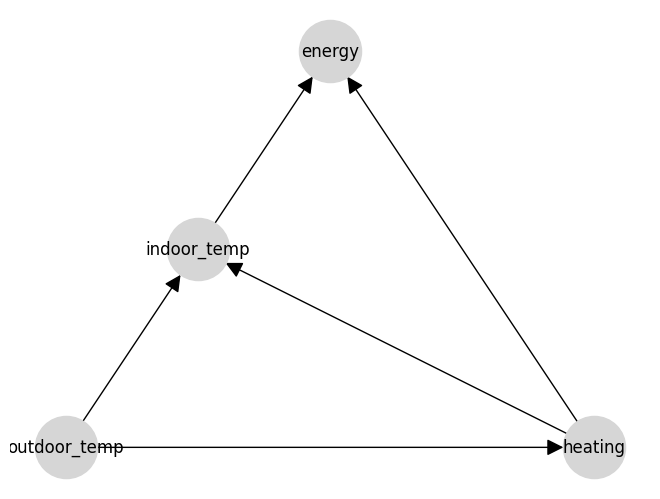

In [18]:
plot_causal_graph(model)

## Training a causal model

Once the model is defined, we can train it on the data we've loaded. This will learn the causal relationships according to the structure defined above. This model will then be ready to query.

In [19]:
model.train("quickstart-heating-data")

## Query: simulating actions

One of the common use cases for a causal model is to simulate the effect of actions. We can do this by setting the value of a variable to a specific value, and then seeing how the other variables change. This is useful for understanding the impact of interventions, or for making predictions.

CausaDB is fully Bayesian, so we can easily access the lower and upper bounds of the predictions as well as the expected value, using the `lower`, `upper`, and `median` keys.

In [20]:
model.simulate_actions(actions={
  "heating": [46, 54],
  "outdoor_temp": [12, 14]
})["median"]

,day,outdoor_temp,heating,indoor_temp,energy
0,0.0,12.0,46.0,16.64040,599.126715
1,0.0,14.0,54.0,18.63764,669.091182


It also works for single values, shown below using the `lower` key for demonstration.

In [21]:
model.simulate_actions(actions={
  "heating": 46,
  "outdoor_temp": 12
})["lower"]

,day,outdoor_temp,heating,indoor_temp,energy
0,0.0,12.0,46.0,16.086163,594.646865


## Query: Finding the best action to take

Probably the most common use case is to find the best action to take. This could be a decision, an optimisation, or a recommendation. We can do this using the `find_best_action` method, which will find the action that achieves an outcome closest to a target value. This can be done while respecting constraints on other variables, or by setting the value of other variables to specific values using the `fixed` parameter.

In [22]:
best_actions = model.find_best_actions(
    targets={"indoor_temp": 19},
    actionable=["heating"],
    fixed={"outdoor_temp": 16}
)

achieved_indoor_temp = set_heating(best_actions["heating"].values, np.array([16]), noise=False)[0]

print(f"Best heating setting: {best_actions['heating'].values[0]:.1f}")
print(f"Indoor temperature achieved: {achieved_indoor_temp[0]:.1f}°C")

Best heating setting: 54.6
Indoor temperature achieved: 19.1°C


## Query: Finding the causal effects of a variable

Another useful query is to find the causal effect of a variable on the others. This can be done using the `causal_effect` method, which will return the expected change in the target variable for a given change in the causal variable. This can be done for a range of values, or for a single value.

In [23]:
model.causal_effects({"heating": [50, 55]}, fixed={"outdoor_temp": 15})

,median,lower,upper
day,0.000000,0.000000,0.000000
outdoor_temp,0.000000,0.000000,0.000000
heating,5.000000,5.000000,5.000000
indoor_temp,1.170629,0.986935,1.333171
energy,43.267641,41.093223,45.469625


## Query: Causal attribution

A similar but distinct query to `causal_effects` is `causal_attributions`, which calculates how much each variable contributes to the value of an outcome variable. This can be useful for understanding the importance of different variables in a system. It's important to interpret these results in the context of the model, as they causal pathways can sometimes be indirect.

In [24]:
causal_attributions = model.causal_attributions("energy")
causal_attributions

,energy
outdoor_temp,-25.394150
heating,8.524143
indoor_temp,4.412946


Causal attributions can also be plotted to visualise the impacts of various variables on the outcome.

<Axes: title={'center': 'Causal attribution of energy'}, xlabel='Causal attribution', ylabel='Node'>

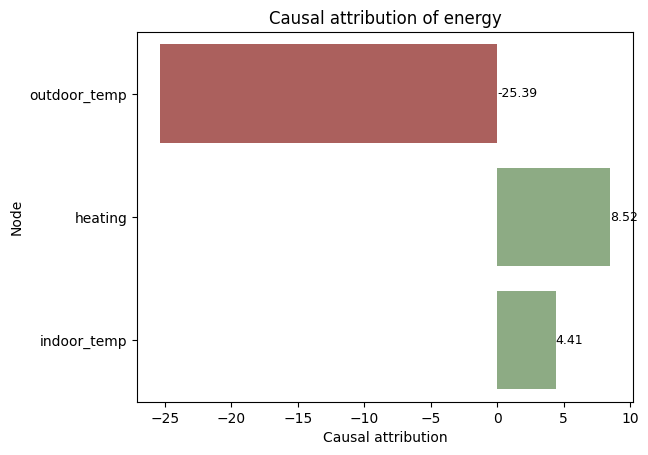

In [25]:

plot_causal_attributions(model, "energy", normalise=False)

There is also a normalised version of the function to show the relative importance of each variable, scaled to sum to 1.

<Axes: title={'center': 'Causal attribution of energy'}, xlabel='Causal attribution', ylabel='Node'>

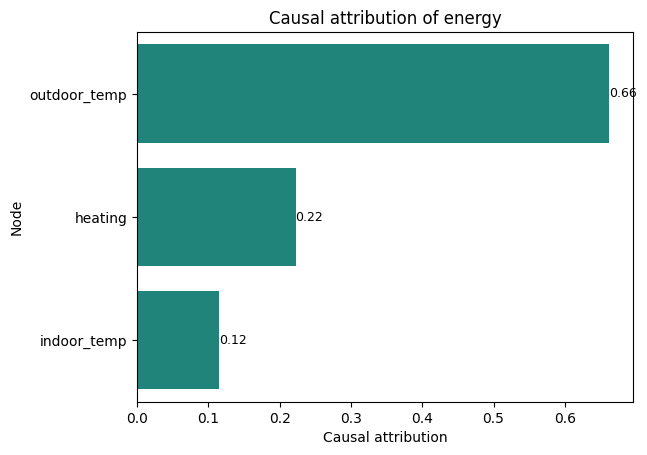

In [26]:
plot_causal_attributions(model, "energy", normalise=True)

## Conclusion

This has been a quick overview of some of the core features of CausaDB. For more information, please refer to the documentation or get in touch with us.